# Dask predict

In [3]:
import os
import sys

path = os.path.abspath('..')
sys.path.append(path)

## Setup Dask Client

In [4]:
import dask.dataframe as dd
import pandas as pd

from dask.distributed import Client
from tqdm import tqdm

from modeling import sentiment_model

In [5]:
client = Client(n_workers=4, threads_per_worker=4, processes=True, memory_limit='4GB')
client

distributed.diskutils - INFO - Found stale lock file and directory '/Users/ep67xw/Desktop/Casa/KlarnaAPI/notebooks/dask-worker-space/worker-qvhe8sfv', purging
distributed.diskutils - INFO - Found stale lock file and directory '/Users/ep67xw/Desktop/Casa/KlarnaAPI/notebooks/dask-worker-space/worker-j75hq1z7', purging
distributed.diskutils - INFO - Found stale lock file and directory '/Users/ep67xw/Desktop/Casa/KlarnaAPI/notebooks/dask-worker-space/worker-70btql72', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 14.90 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:53884,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 14.90 GiB
Comm: tcp://127.0.0.1:53989,Total threads: 4
Dashboard: http://127.0.0.1:54002/status,Memory: 3.73 GiB
Nanny: tcp://127.0.0.1:53887,


## Compute model predictions

In [6]:
def get_preds(df_text):
    probs = sentiment_model.get_prediction_probs(df_text['text'])
    df_text['pred'] = [p['pos'] for p in probs]
    return df_text

In [7]:
meta = pd.DataFrame({'text': ['foo'], 'pred': [1.0]})
df = pd.read_csv('./data/combined.csv', usecols=['text'], lineterminator='\n')
ddf = dd.from_pandas(df, chunksize=10**5).fillna('')

In [8]:
ddf.map_partitions(get_preds, meta=meta).to_csv('./data/predictions2/predictions-*.csv')  

/Users/ep67xw/opt/anaconda3/envs/casa/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:1322: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(
/Users/ep67xw/opt/anaconda3/envs/casa/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:1322: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(
/Users/ep67xw/opt/anaconda3/envs/casa/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:1322: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(
/Users/ep67xw/opt/anaconda3/envs/casa/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:1322: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched 

['/Users/ep67xw/Desktop/Casa/KlarnaAPI/notebooks/./data/predictions2/predictions-00.csv',
 '/Users/ep67xw/Desktop/Casa/KlarnaAPI/notebooks/./data/predictions2/predictions-01.csv',
 '/Users/ep67xw/Desktop/Casa/KlarnaAPI/notebooks/./data/predictions2/predictions-02.csv',
 '/Users/ep67xw/Desktop/Casa/KlarnaAPI/notebooks/./data/predictions2/predictions-03.csv',
 '/Users/ep67xw/Desktop/Casa/KlarnaAPI/notebooks/./data/predictions2/predictions-04.csv',
 '/Users/ep67xw/Desktop/Casa/KlarnaAPI/notebooks/./data/predictions2/predictions-05.csv',
 '/Users/ep67xw/Desktop/Casa/KlarnaAPI/notebooks/./data/predictions2/predictions-06.csv',
 '/Users/ep67xw/Desktop/Casa/KlarnaAPI/notebooks/./data/predictions2/predictions-07.csv',
 '/Users/ep67xw/Desktop/Casa/KlarnaAPI/notebooks/./data/predictions2/predictions-08.csv',
 '/Users/ep67xw/Desktop/Casa/KlarnaAPI/notebooks/./data/predictions2/predictions-09.csv',
 '/Users/ep67xw/Desktop/Casa/KlarnaAPI/notebooks/./data/predictions2/predictions-10.csv',
 '/Users/e

In [9]:
import glob

from os.path import dirname, abspath

repo_path = dirname(os.getcwd())
path = repo_path + '/notebooks/data/predictions2'
all_files = glob.glob(path + "/*.csv")

li = []

for filename in tqdm(sorted(all_files)):
    df = pd.read_csv(filename, index_col=0, header=0, lineterminator='\n')
    li.append(df)

df_pred = pd.concat(li, axis=0, ignore_index=True)

100%|███████████████████████████████████████████| 40/40 [00:10<00:00,  3.75it/s]


In [18]:
df_pred.to_csv('./data/predictions2/predictions.csv')

TypeError: to_csv() got an unexpected keyword argument 'lineterminator'

In [19]:
df_pred = pd.read_csv('./data/predictions1/predictions1.csv', lineterminator='\n')

In [20]:
df_pred.shape

(4000000, 3)

## Model performance for both positive and negative sentiment on 4M dataset
Note: the model is trained on a random 20% of this data!

In [11]:
import numpy as np

from sklearn.metrics import f1_score, precision_score, accuracy_score, recall_score

In [21]:
y_true = (df_pred.index > 2000000).astype(int)

In [22]:
f1 = []
accuracy = []
precision = []
recall = []

for t in np.arange(0, 1, 0.05):
    y_pred = (df_pred['pred'] > t).astype(int)
    
    # Scores
    f1.append(f1_score(y_true, y_pred))
    accuracy.append(accuracy_score(y_true, y_pred))
    precision.append(precision_score(y_true, y_pred))
    recall.append(recall_score(y_true, y_pred))

In [23]:
df_scores = pd.DataFrame({
    'threshold': np.arange(0, 1, 0.05),
    'f1': f1,
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
})

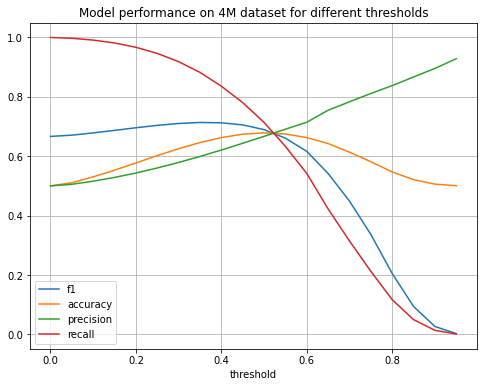

In [24]:
ax = df_scores.set_index('threshold').plot(figsize=(8, 6));
ax.grid(True);
ax.set_title("Model performance on 4M dataset for different thresholds");